In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np 
import math

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TH1391_NLMH/Week8_Thuchanh2/outcome.csv')
data

,District,House Type,Income,Previous Customer,Outcome
0,Suburban,Detached,High,No,Not responded
1,Suburban,Detached,High,Yes,Not responded
2,Rural,Detached,High,No,Responded
3,Urban,Semi-detached,High,No,Responded
4,Urban,Semi-detached,Low,No,Responded
5,Urban,Semi-detached,Low,Yes,Not responded
6,Rural,Semi-detached,Low,Yes,Responded
7,Suburban,Terrace,High,No,Not responded
8,Suburban,Semi-detached,Low,No,Responded
9,Urban,Terrace,Low,No,Responded


In [ ]:
#data_train.iloc[:-1, 1:].values # [số hàng; số cột]

In [ ]:
# Tạo thuộc tính
attribute = list(data.columns) # Dùng header để lấy thuộc tính
attribute

['District', 'House Type', 'Income', 'Previous Customer', 'Outcome']

In [ ]:
# Xác định các thuộc tính dữ liệu
data_train = data[attribute]
# data_train = data_train.iloc[:-2]
data_train

,District,House Type,Income,Previous Customer,Outcome
0,Suburban,Detached,High,No,Not responded
1,Suburban,Detached,High,Yes,Not responded
2,Rural,Detached,High,No,Responded
3,Urban,Semi-detached,High,No,Responded
4,Urban,Semi-detached,Low,No,Responded
5,Urban,Semi-detached,Low,Yes,Not responded
6,Rural,Semi-detached,Low,Yes,Responded
7,Suburban,Terrace,High,No,Not responded
8,Suburban,Semi-detached,Low,No,Responded
9,Urban,Terrace,Low,No,Responded


In [ ]:
class Tree:
  def __init__(self,observationIDs,features,currLvl=0,subTree={},bestFeature=None,majorityLabel=None,parentMajorityLabel=None):
    self.observationIDs = observationIDs
    self.features = features
    self.currLvl = currLvl
    self.subTree = subTree
    self.bestFeature = bestFeature
    self.majorityLabel = majorityLabel
    self.parentMajorityLabel = parentMajorityLabel
    self.setBestFeatureID(bestFeature)
    
  def setBestFeatureID(self, feature): # Chọn thuộc tính tốt nhất
    idx = None
    if feature == 'District':
      idx = 0
    elif feature == 'House Type':
      idx = 1
    elif feature == 'Income':
      idx = 2
    else:
      idx = 3
    self.bestFeatureID = int(idx)

In [ ]:
# Hàm dự đoán
def predict(tree, obs): # đư đoán dữ lieu bat ky
	if tree.bestFeature == None:
		return tree.majorityLabel
	featVal = obs[tree.bestFeatureID]
	if not featVal in tree.subTree: # val with no subtree
		return tree.majorityLabel
	else: # recurse on subtree
		return predict(tree.subTree[featVal],obs)

In [ ]:
# Hàm hiểm thị cây
def displayDecisionTree(tree):
	print('\t'*tree.currLvl + '(lvl {}) {}'.format(tree.currLvl,tree.majorityLabel))
	if tree.bestFeature == None:
		return

	print('\t'*tree.currLvl + '{}'.format(tree.bestFeature) + ': ')
	for [val,subTree] in sorted(tree.subTree.items()):
		print('\t'*(tree.currLvl+1) + 'choice: {}'.format(val))
		displayDecisionTree(subTree)

In [ ]:
# Hàm tính Entropy
def Entropy(ns): # Phai tinh toan
	entropy = 0.0
	total = sum(ns)
	for x in ns:
		entropy += -1.0*x/total*math.log(1.0*x/total,2)
	return entropy

In [ ]:
# ID3 - Information Gain
def IG(observationIDs, feature,dfdata):
	# get smaller dataframe
	df = dfdata.loc[list(observationIDs)]
	# populate counts for Wins/Losses for each category of the feature
	labelCountDict = {}
	valueLabelCountDict = {}
	for index, row in df.iterrows():
		label = row['Outcome'] # !!! Mục tiêu là chổ này
		if not label in labelCountDict:
			labelCountDict[label] = 0 # this specific label was not found so insert 0 count
		labelCountDict[label] += 1
		featureValue = row[feature]
		if not featureValue in valueLabelCountDict:
			valueLabelCountDict[featureValue] = {} # this specific feature value not found so insert empty dict
		if not label in valueLabelCountDict[featureValue]:
			valueLabelCountDict[featureValue][label] = 0 # this specific label was not found for this feature value so insert 0 count
		valueLabelCountDict[featureValue][label] += 1

	ns = []
	for [label,count] in labelCountDict.items():
		ns.append(count)

	H_Y = Entropy(ns) # Hàm tính Entropy

	H_Y_X = 0.0
	for [featureValue, labelCountDict] in valueLabelCountDict.items():
		nsHYX = []
		for [label,count] in labelCountDict.items():
			nsHYX.append(count)
		H_Y_X += 1.0*sum(nsHYX)/len(df)*Entropy(nsHYX)
	return H_Y - H_Y_X

In [ ]:
# C4.5 - Gain Ratio
def GR(observationIDs, feature, dfdata):
	ig = IG(observationIDs,feature, dfdata)
	if ig == 0:
		return 0
	df = dfdata.loc[list(observationIDs)]
	valueLabelDict = {}
	for index, row in df.iterrows():
		label = attribute[-1]
		featureValue = row[feature]
		if featureValue not in valueLabelDict:
			valueLabelDict[featureValue] = 0
		valueLabelDict[featureValue] += 1
	ns = []
	for [val,count] in valueLabelDict.items():
		ns.append(count)
	ent = Entropy(ns)
	return float(ig)/ent

In [ ]:
# Xây dựng cây quyết định
def fillDecisionTree(tree, decisionTreeAlgo, dfdata): 
	# find the majorityLabel
	df = dfdata.loc[list(tree.observationIDs)] # smaller df
	counts = df['Outcome'].value_counts()                       # !!! chỉnh phần này lại
	majorityLabel = df['Outcome'].value_counts().idxmax()
	if len(counts) > 1:
		if counts['Responded'] == counts['Not responded']: 
			majorityLabel = tree.parentMajorityLabel
	tree.majorityLabel = majorityLabel

	# exit if only one label  # !!! Nhiều cái phân loại thêm vao day
	if len(counts) == 1:
		return
	# exit if no features left
	if len(tree.features) == 0:  
		return

	# find best feature
	featureValueDict = {}
	for feature in tree.features: 
		if decisionTreeAlgo == 'ID3':
			metricScore = IG(tree.observationIDs,feature,dfdata)
		if decisionTreeAlgo == 'C45':
			metricScore = GR(tree.observationIDs,feature,dfdata)
		featureValueDict[feature] = metricScore
	bestFeature, bestFeatureValue = sorted(featureValueDict.items(),reverse=True)[0]
	# exit if IG or GR is 0
	if bestFeatureValue == 0.0:
		return
	tree.bestFeature = bestFeature

	# find subset of features
	subFeatures = set()
	for feature in tree.features:
		if feature == bestFeature: # skip the current best feature
			continue
		subFeatures.add(feature)
	
	# find best feature id # !!! Tự fix
	bestFeatureIdx = 0
	if bestFeature == 'District':
		bestFeatureIdx = 0
	elif bestFeature == 'House Type':
		bestFeatureIdx = 1
	elif bestFeature == 'Income':
		bestFeatureIdx = 2
	else:
		bestFeatureIdx = 3
	
	# find subset of observations
	subObservationsDict = {}
	for obs in tree.observationIDs:
		val = dfdata.values[obs][bestFeatureIdx]
		if not val in subObservationsDict:
			subObservationsDict[val] = set()
		subObservationsDict[val].add(obs)

	for [val,obs] in subObservationsDict.items():

		tree.subTree[val] = Tree(obs, subFeatures, tree.currLvl + 1,{},None,None,majorityLabel)
		
		fillDecisionTree(tree.subTree[val], decisionTreeAlgo, dfdata)

In [ ]:
initialObservationIDs = set(range(len(data_train)))
initialFeatures = set(data_train.columns.values[:-1])

In [ ]:
# Lựa chọn thuật toán
algoChoice = str(input(("Which decision tree algorithm would you like to use ('ID3' or 'C45)?")))
if algoChoice not in {'ID3','C45'}:
	print("Invalid algorithm choice. You must choose 'ID3' or 'C45'")
	exit()

print("choice: {}".format(algoChoice))

Which decision tree algorithm would you like to use ('ID3' or 'C45)?ID3
choice: ID3


In [ ]:
# Hiểm thị cây
MyTree = Tree(initialObservationIDs,initialFeatures)
fillDecisionTree(MyTree, algoChoice, data_train) # In cây ra

print('My Decision Tree:')
displayDecisionTree(MyTree)

My Decision Tree:
(lvl 0) Responded
Previous Customer: 
	choice: No
	(lvl 1) Responded
	Income: 
		choice: High
		(lvl 2) Responded
		House Type: 
			choice: Detached
			(lvl 3) Responded
			District: 
				choice: Rural
				(lvl 4) Responded
				choice: Suburban
				(lvl 4) Not responded
			choice: Semi-detached
			(lvl 3) Responded
			choice: Terrace
			(lvl 3) Not responded
		choice: Low
		(lvl 2) Responded
	choice: Yes
	(lvl 1) Responded
	Income: 
		choice: High
		(lvl 2) Not responded
		House Type: 
			choice: Detached
			(lvl 3) Not responded
			choice: Terrace
			(lvl 3) Not responded
			District: 
				choice: Rural
				(lvl 4) Responded
				choice: Urban
				(lvl 4) Not responded
		choice: Low
		(lvl 2) Responded
		House Type: 
			choice: Semi-detached
			(lvl 3) Responded
			District: 
				choice: Rural
				(lvl 4) Responded
				choice: Urban
				(lvl 4) Not responded
			choice: Terrace
			(lvl 3) Responded


In [ ]:
data

,District,House Type,Income,Previous Customer,Outcome
0,Suburban,Detached,High,No,Not responded
1,Suburban,Detached,High,Yes,Not responded
2,Rural,Detached,High,No,Responded
3,Urban,Semi-detached,High,No,Responded
4,Urban,Semi-detached,Low,No,Responded
5,Urban,Semi-detached,Low,Yes,Not responded
6,Rural,Semi-detached,Low,Yes,Responded
7,Suburban,Terrace,High,No,Not responded
8,Suburban,Semi-detached,Low,No,Responded
9,Urban,Terrace,Low,No,Responded


In [ ]:
X_p8 = data.loc[7].iloc[:-1]
obs_row = X_p8.tolist()
pred = predict(MyTree, obs_row)
print(f'Prediction for {obs_row}: {pred}')

Prediction for ['Suburban', 'Terrace', 'High', 'No']: Responded


In [ ]:
X_p13 = data.iloc[-3, :-1]
obs_row = X_p13.tolist()
pred = predict(MyTree, obs_row)
print(f'Prediction for {obs_row}: {pred}')

Prediction for ['Rural', 'Terrace', 'High', 'Yes']: Responded


In [ ]:
X_p14 = data.iloc[-2, :-1]
obs_row = X_p14.tolist()
pred = predict(MyTree, obs_row)
print(f'Prediction for {obs_row}: {pred}')

Prediction for ['Rural', 'Detached', 'Low', 'No']: Responded


In [ ]:
X_p15 = data.iloc[-1, :-1]
obs_row = X_p15.tolist()
pred = predict(MyTree, obs_row)
print(f'Prediction for {obs_row}: {pred}')

Prediction for ['Urban', 'Terrace', 'High', 'Yes']: Responded


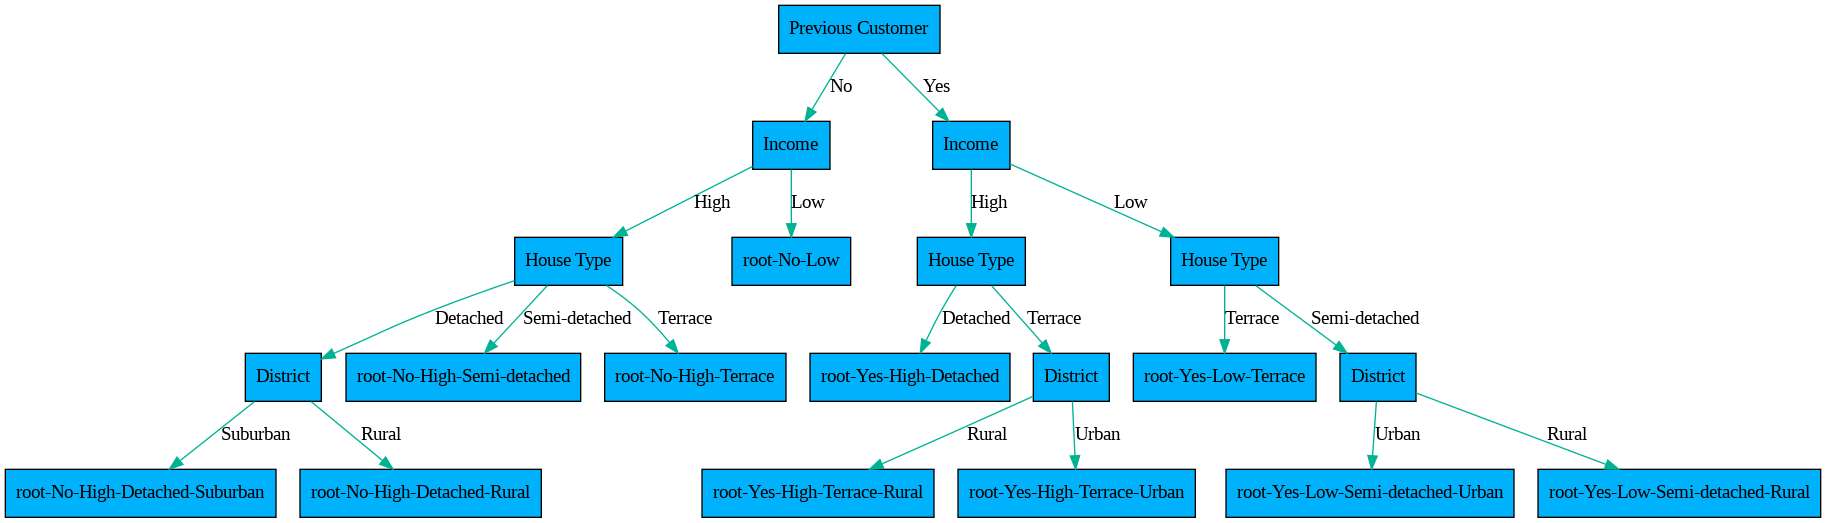

In [ ]:
# Vẽ hình
from IPython.display import Image
import pydotplus
import graphviz

def visualize_tree(tree, feature_names=attribute, class_names=data[data.columns[-1]].unique(), label='root'):
    if tree.bestFeature is None:
        node_attr = {'shape': 'plaintext', 'style': 'filled', 'fillcolor': 'limegreen'}
        return graphviz.Digraph(node_attr=node_attr, format='png').node(label, f"{tree.majorityLabel}")

    dot = graphviz.Digraph(node_attr={'shape': 'box', 'style': 'filled', 'fillcolor': '#00B2FC'}, format='png')
    dot.node(label, tree.bestFeature)

    for val, sub_tree in tree.subTree.items():
        sub_label = f"{label}-{val}"
        dot.subgraph(visualize_tree(sub_tree, feature_names, class_names, sub_label))
        dot.edge(label, sub_label, label=f"{val}", color='#00B294')

    return dot

dot = visualize_tree(MyTree)
graph = pydotplus.graph_from_dot_data(dot.source)
Image(graph.create_png())